<h1>ML Recurrent Neural Network Example</h1>
This example demonstrates classification of time-series data from the force-torque sensor to detect grasping failure. The data is taken from the <a href="https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures">Robot execution failures</a> dataset. It consists of 87 labeled instances of sequences of 15 F/T measurements and class labels.

The data is parsed into a pandas dataframe, broken into training and test set, and run through a recurrent neural network using keras. 


In [1]:
# Import data processing tools
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib ipympl

import numpy as np

# Import ML tools
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import np_utils

# Import tools needed for visualization
from IPython.display import Image, display


Using TensorFlow backend.


The dataset consists of time series of 6-DoF force/torque measurements that are labeled with success ('normal') or failure ('obstruction', 'collision', 'fr_collision'). The raw data can be inspected <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/robotfailure-mld/lp1.data">here</a> and needs to be converted in table format. <br><br>
The code for parsing the data has been adopted from a <a href="https://tsfresh.readthedocs.io/en/latest/_modules/tsfresh/examples/robot_execution_failures.html">tsfresh tutorial</a>. It proceeds by reading the data file line by line and storing an entire time series in a single row. Sucess and the various failure modes are coded as a boolean value. 

In [2]:
    id_to_target = {}
    df_rows = []
    df_block = []

    with open('lp1.data') as f:
        cur_id = 0
        time = 0

        for line in f.readlines():
            # New sample --> increase id, reset time and determine target
            if line[0] not in ['\t', '\n']:               
                time = 0
                #id_to_target[cur_id] = line.strip()
                id_to_target[cur_id] = (line.strip()=='normal')
                if(df_block): 
                    df_rows.append(np.array(df_block).reshape(1,90)[0].tolist())
                df_block = []
                cur_id += 1
            # Data row --> split and convert values, create complete df row
            elif line[0] == '\t':
                values = list(map(int, line.split('\t')[1:]))
                #df_rows.append([cur_id, time] + values)
                df_block.append(values)
                time += 1
        df_rows.append(np.array(df_block).reshape(1,90)[0].tolist())

    columns=[]
    for i in range(0,15):
        columns=columns+['F_x'+str(i), 'F_y'+str(i), 'F_z'+str(i), 'T_x'+str(i), 'T_y'+str(i), 'T_z'+str(i)]
    
    df = pd.DataFrame(df_rows, columns=columns) # Store all data in a Pandas dataframe
    y = pd.Series(id_to_target) # Store all class labels in a Pandas series

In [4]:
df.tail()

,F_x0,F_y0,F_z0,T_x0,T_y0,T_z0,F_x1,F_y1,F_z1,T_x1,...,F_z13,T_x13,T_y13,T_z13,F_x14,F_y14,F_z14,T_x14,T_y14,T_z14
83,-29,-10,-208,180,12,-11,-29,-4,-246,192,...,-918,396,101,-23,-105,63,-912,394,100,-25
84,4,6,50,-25,1,0,4,8,44,-26,...,4,-46,14,-7,19,14,2,-42,10,-7
85,21,15,-14,-46,16,-7,23,18,-27,-49,...,-346,-88,154,4,148,69,-411,-95,191,8
86,171,86,-486,-113,222,13,198,96,-566,-125,...,-1036,-118,466,44,342,154,-1036,-118,466,44
87,-6,3,52,-15,-17,3,-7,2,52,-17,...,26,-29,-27,5,-13,2,15,-25,-25,6


In [6]:
y.tail()

83    False
84    False
85    False
86    False
87    False
dtype: bool

In [16]:
labels=y
features=np.array(df).astype(int)
features.reshape(88,6,15)
#feature_list=list(df.columns)

labels=labels.astype(int)
categorical_labels = np_utils.to_categorical(labels, num_classes=2).astype(int)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(features, categorical_labels, test_size = 0.2)

In [18]:
X_train=X_train.reshape(X_train.shape[0],15,6)
X_test=X_test.reshape(X_test.shape[0],15,6)

In [51]:
from keras.layers import Bidirectional
HIDDEN_SIZE = 72
NUM_ITERATIONS = 25
NUM_EPOCHS_PER_ITERATION = 1
#NUM_PREDS_PER_EPOCH = 100

model = Sequential()
#model.add(Bidirectional(SimpleRNN(HIDDEN_SIZE, return_sequences=False,unroll=True),input_shape=(15, 6)))
model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=False,unroll=True,input_shape=(15, 6)))
#model.add(Dense(HIDDEN_SIZE,input_shape=(15,6)))
model.add(Dense(HIDDEN_SIZE))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation("softmax"))
model.summary()
model.compile(loss='binary_crossentropy',optimizer="rmsprop")


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 72)                5688      
_________________________________________________________________
dense_39 (Dense)             (None, 72)                5256      
_________________________________________________________________
activation_35 (Activation)   (None, 72)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 146       
_________________________________________________________________
activation_36 (Activation)   (None, 2)                 0         
Total params: 11,090
Trainable params: 11,090
Non-trainable params: 0
_________________________________________________________________


In [52]:
NB_EPOCH=200
BATCH_SIZE = 8
VERBOSE = 1
VALIDATION_SPLIT = 0.2

history = model.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 56 samples, validate on 14 samples
Epoch 1/200
56/56 [==============================] - 0s 6ms/step - loss: 0.6011 - val_loss: 0.4340
Epoch 2/200
56/56 [==============================] - 0s 317us/step - loss: 0.4533 - val_loss: 0.4599
Epoch 3/200
56/56 [==============================] - 0s 289us/step - loss: 0.3936 - val_loss: 0.4100
Epoch 4/200
56/56 [==============================] - 0s 306us/step - loss: 0.3613 - val_loss: 0.4069
Epoch 5/200
56/56 [==============================] - 0s 276us/step - loss: 0.3570 - val_loss: 0.5216
Epoch 6/200
56/56 [==============================] - 0s 306us/step - loss: 0.3363 - val_loss: 0.5336
Epoch 7/200
56/56 [==============================] - 0s 278us/step - loss: 0.3413 - val_loss: 0.4700
Epoch 8/200
56/56 [==============================] - 0s 313us/step - loss: 0.3492 - val_loss: 0.4387
Epoch 9/200
56/56 [==============================] - 0s 277us/step - loss: 0.3224 - val_loss: 0.5032
Epoch 10/200
56/56 [=============================

In [47]:
predictions = np.round(model.predict(X_test))

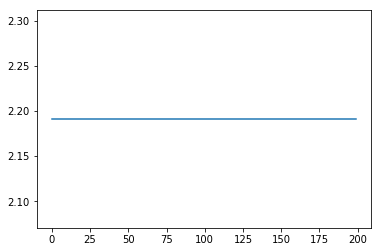

In [48]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])

<h2>Results</h2>
We can now compare the predictions made by the random forest with the known labels from the test set and calculate the percentage of errorneous predictions. 

In [35]:
errors = abs(predictions-Y_test)

In [36]:
print('Error: ',sum(errors)/len(Y_test)*100,'%')

Error:  [5.55555556 5.55555556] %
